Projet réalisé par :\
Mahmoud Benboubker\
Nicolas Calligaro\
Aïcha Lalhou


# Etude Approfondie du RSSI 
Dans ce notebook, nous nous sommes intéressé à l'étude des RSSI, et donc plus particulièrement de la variable 'rssi'.
Ce notebook 
- Regroupe l'étude de la relation entre distance et RSSI 
- Met en avant la formule utilisée dans le calcul du barycentre
- Met en avant les distances abérantes dans le dataset

Nous avons également mis en avant  (à la fin de ce notebook) les conclusions tirées de cette étude, que nous avons appliquées aux autre approches. 

In [1]:
import pandas as pd
import numpy as np
from IotTools import *
from IpyTools import *
from ipyleaflet import Map, basemaps
from vincenty import vincenty
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [3]:
#Coordonné d'origine des messages
pos_train['messid'] = df_mess_train.messid
msg_coord = pos_train.groupby('messid').mean()
msg_coord.head(1)

,lat,lng
messid,,
573bf1d9864fce1a9af8c5c9,39.60669,-104.95849


# On repositionne les bases outliers

In [4]:
X_train = Correct_Bases (df_mess_train)

Nous avons 27 bases outliers
Base 9949 non vu
il reste 0 base avec lat >60


# On va produire une nouvelle feature : la distance du message par rapport à la base l'ayant percu

In [5]:
X_train['dist']=0
for i in X_train.index:
    base_coord = (X_train.iloc[i].bs_lat,X_train.iloc[i].bs_lng)
    mess_coord = (msg_coord.loc[X_train.iloc[i].messid].lat,msg_coord.loc[X_train.iloc[i].messid].lng)
    X_train.loc[i,'dist']=vincenty(base_coord,mess_coord)
X_train.head(1)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,dist
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,1.270478


<AxesSubplot:>

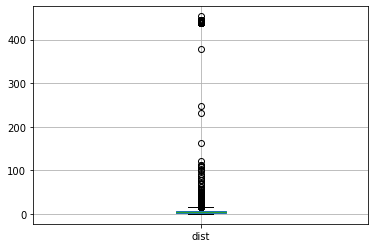

In [6]:
X_train[['dist']].boxplot()

In [7]:
Q2,Q3 = np.quantile(X_train[['dist']],[0.5,0.75])
Qmax = Q3+(1.5*(Q3-Q2))
Qmax,X_train['dist'].max(),X_train['dist'].min()

(12.276497750000003, 453.352103, 0.022597)

In [8]:

(X_train['dist']>Qmax).value_counts()

False    35979
True      3271
Name: dist, dtype: int64

### En moyenne la distance va de 0Km à 13Km. Mais on a également une variance jusqu'à 453Km On va considérer que les msg capté à + de 13Km sont des erreurs. 3271 Vs 32896 écartons ces erreurs

<AxesSubplot:>

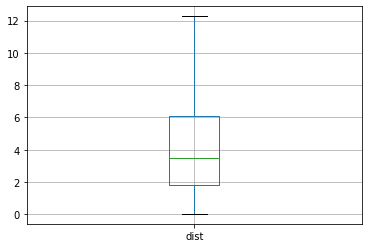

In [9]:
X_reduce = X_train[X_train['dist']<=Qmax]
X_reduce[['dist']].boxplot()

# Etudions la relation entre distance et Rssi

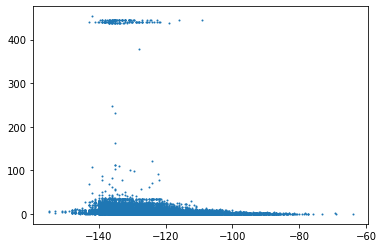

In [10]:
#Avec toutes les distances
plt.scatter(X_train['rssi'].values,X_train['dist'].values,s=1);

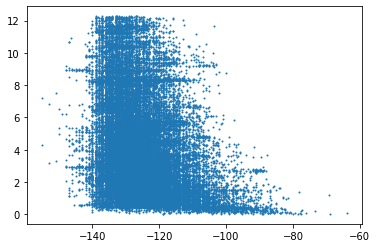

In [11]:
#En retirant les distances outliers
plt.scatter(X_reduce['rssi'].values,X_reduce['dist'].values,s=1);

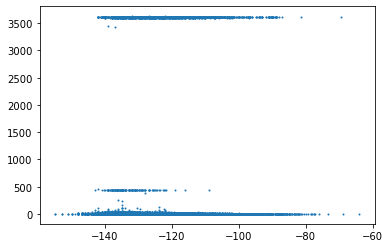

In [12]:
#Nb avec les bases outliers
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_train['dist']=0
for i in df_mess_train.index:
    base_coord = (df_mess_train.iloc[i].bs_lat,df_mess_train.iloc[i].bs_lng)
    mess_coord = (msg_coord.loc[df_mess_train.iloc[i].messid].lat,msg_coord.loc[df_mess_train.iloc[i].messid].lng)
    df_mess_train.loc[i,'dist']=vincenty(base_coord,mess_coord)
df_mess_train.head(1)
plt.scatter(df_mess_train['rssi'].values,df_mess_train['dist'].values,s=1);

In [13]:
X_reduce['rssi'].describe()

count    35979.000000
mean      -125.384868
std          9.336589
min       -155.000000
25%       -132.000000
50%       -127.000000
75%       -120.500000
max        -64.000000
Name: rssi, dtype: float64

<AxesSubplot:ylabel='Frequency'>

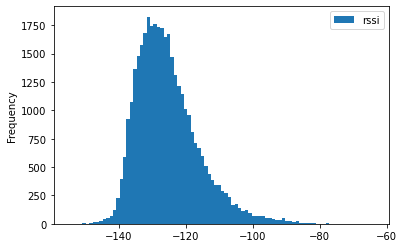

In [14]:
X_reduce[['rssi']].plot(kind='hist',bins=90)

<AxesSubplot:>

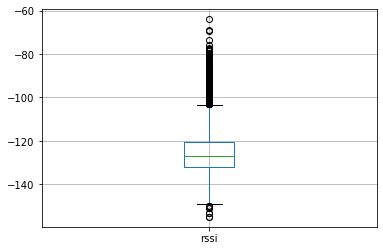

In [15]:
X_reduce[['rssi']].boxplot()

In [16]:
Q2,Q3 = np.quantile(X_reduce[['rssi']],[0.5,0.75])
Qmax = Q3+(1.5*(Q3-Q2))
Qmax

-110.75

In [17]:
(X_reduce['rssi']>Qmax).value_counts()

False    33287
True      2692
Name: rssi, dtype: int64

# Créons une relation linéaire entre Rssi et distance

In [18]:
X_reduce['rssi_reshape']=(10**(X_reduce['rssi']/10))
X_reduce.head(1)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,dist,rssi_reshape
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,1.270478,7.079458e-13


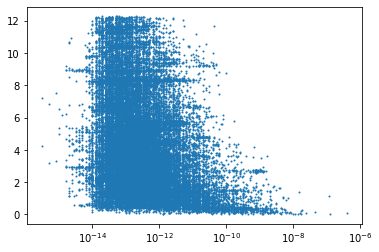

In [19]:
plt.xscale('log')
plt.scatter(X_reduce['rssi_reshape'].values,X_reduce['dist'].values,s=1);

In [20]:
X_reduce['rssi_reshape'].describe()

count    3.597900e+04
mean     3.847462e-11
std      2.320296e-09
min      3.162278e-16
25%      6.309573e-14
50%      1.995262e-13
75%      8.912509e-13
max      3.981072e-07
Name: rssi_reshape, dtype: float64

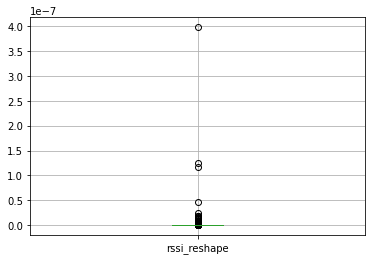

In [21]:
X_reduce[['rssi_reshape']].boxplot();

# La mesure Rssi_Reshape sépare mieux les différentes valeurs 

In [22]:
Q2,Q3 = np.quantile(X_reduce[['rssi_reshape']],[0.5,0.75])
Qmax = Q3+(1.5*(Q3-Q2))
Qmax

1.9288379980890275e-12

In [23]:
(X_reduce['rssi_reshape']>Qmax).value_counts()

False    29912
True      6067
Name: rssi_reshape, dtype: int64

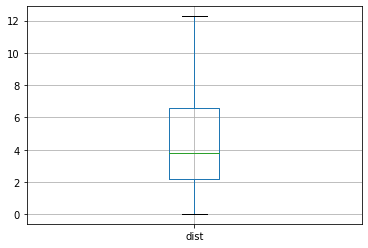

In [24]:
X_reduce[X_reduce['rssi_reshape']<Qmax][['dist']].boxplot();

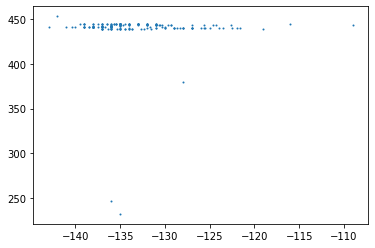

In [25]:
X_out = X_train[X_train['dist']>200]
plt.scatter(X_out['rssi'].values,X_out['dist'].values,s=1);

# Conclusion¶
Il existe une relation logarithmique entre le Rssi et la distance.

Cependant il est à prendre en considération, dans notre cas, que les obstacles influent également sur le Rssi.
Ainsi il nous est impossible d'utiliser cette relation pour définir la distance.
(elle apparait en contour du nuage de point). 

Nous avons également mis en évidence des distances abhérantes de détection de messages: 
Une hypothèse serait a faire tester/ validée, mais ne sera pas mise en oeuvre dans le cadre de ce projet:
Un message capté à plus de 20 Km ne doit pas être considéré dans l'apprentissage, car techniquement il ne devrait pas être perçu par cette base. 

Cependant, nous avons identifié une liste de devices qui possèdent des messages captés à une distance lontaine (100Km). Nous avons remarqué qu'en les retirant  de l'échantillon d'apprentissage, nous améliorons la  qualité de prédiction.